In [1]:
# Block 1: Imports, Config, and Helpers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- File Paths ---
# We use the same stereo pair as Q4
left_img_path = r"..\000057_10-image2.png"
right_img_path = r"..\000057_10-image3.png"

# --- Output Config ---
output_dir_q5 = Path("./outputs_q5")
output_dir_q5.mkdir(parents=True, exist_ok=True)

# --- KITTI Camera Parameters (Same as Q4) ---
FOCAL_LENGTH_PIXELS = 721.5   # f_x
BASELINE_METERS = 0.54        # b

# --- Obstacle Detection Config ---
# We will detect all objects CLOSER than this distance.
# Try changing this value (e.g., to 10 or 40) to see the effect.
DEPTH_THRESHOLD_METERS = 20.0

# --- Helper Function ---
def imshow(ax, img, title="", cmap=None):
    """Helper function to display images with matplotlib."""
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

In [2]:
# Block 2: Load Stereo Image Pair
# Load the grayscale images for disparity calculation
imgL_gray = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
imgR_gray = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

# Load the COLOR left image for the final visualization
imgL_color = cv2.imread(left_img_path, cv2.IMREAD_COLOR)

if imgL_gray is None or imgR_gray is None or imgL_color is None:
    print(f"Error: Could not load images. Check paths.")
else:
    print(f"Stereo pair loaded successfully: {imgL_gray.shape}")

Stereo pair loaded successfully: (375, 1242)


In [3]:
# Block 3: Compute Disparity Map (Same as Q4)
# We must re-compute the disparity map to get the depth data.
print("Configuring StereoSGBM and computing disparity...")

minDisparity = 0
numDisparities = 128
blockSize = 5
P1 = 8 * 1 * blockSize**2
P2 = 32 * 1 * blockSize**2
disp12MaxDiff = 1
uniquenessRatio = 10
speckleWindowSize = 100
speckleRange = 32

stereo = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12MaxDiff,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    mode=cv2.StereoSGBM_MODE_SGBM_3WAY
)

disparity_SGBM = stereo.compute(imgL_gray, imgR_gray)
disparity = disparity_SGBM.astype(np.float32) / 16.0
print("Disparity computation complete.")

Configuring StereoSGBM and computing disparity...
Disparity computation complete.


In [4]:
# Block 4: Convert Disparity to Depth Map (Same as Q4)
print("Converting disparity to depth map...")

# The formula is: depth = (focal_length * baseline) / disparity
depth_map = np.zeros_like(disparity, dtype=np.float32)

# Create a mask of valid disparity values (must be > 0)
valid_mask = disparity > 0

# Calculate depth ONLY for valid disparity pixels
depth_map[valid_mask] = (FOCAL_LENGTH_PIXELS * BASELINE_METERS) / disparity[valid_mask]

print("Depth map calculation complete.")

Converting disparity to depth map...
Depth map calculation complete.


Detecting obstacles closer than 20.0 meters...
Saved obstacle mask to D:\git\Image and Video Processing\Lab_4\QUESTION5\outputs_q5


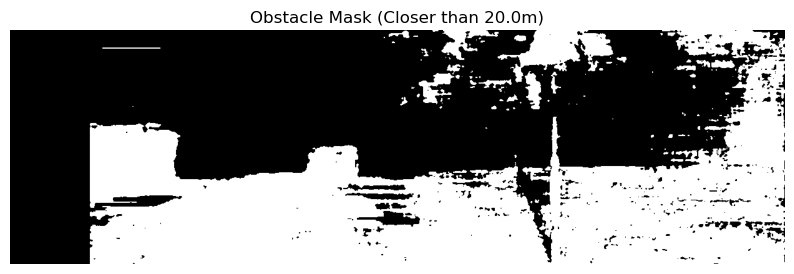

In [5]:
# Block 5: Detect Obstacles based on Depth Threshold
print(f"Detecting obstacles closer than {DEPTH_THRESHOLD_METERS} meters...")

# We need to find all pixels that are BOTH:
# 1. Valid (depth_map > 0)
# 2. Closer than our threshold (depth_map < DEPTH_THRESHOLD_METERS)

obstacle_mask = (depth_map > 0) & (depth_map < DEPTH_THRESHOLD_METERS)

# This `obstacle_mask` is a boolean (True/False) array.
# Let's see what it looks like.
obstacle_mask_vis = (obstacle_mask * 255).astype(np.uint8) # Convert True/False to 255/0


fig, ax = plt.subplots(figsize=(10, 8))
imshow(ax, obstacle_mask_vis, f"Obstacle Mask (Closer than {DEPTH_THRESHOLD_METERS}m)", cmap="gray")
fig.savefig(output_dir_q5 / "q5_obstacle_mask.png", bbox_inches='tight')
print(f"Saved obstacle mask to {output_dir_q5.resolve()}")
plt.show()

Creating overlay visualization...
Saved overlay visualization to D:\git\Image and Video Processing\Lab_4\QUESTION5\outputs_q5


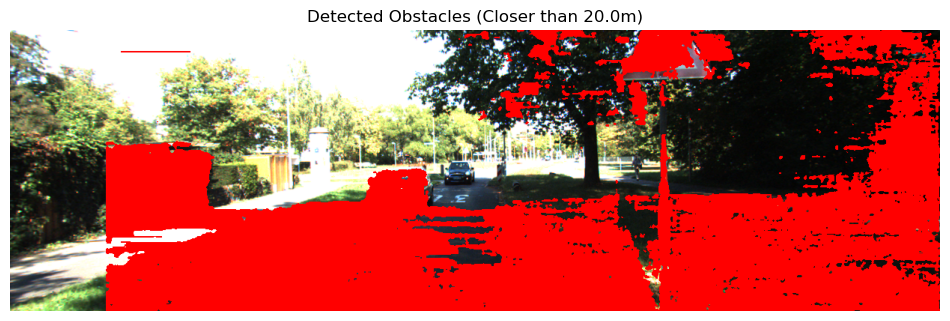

In [6]:
# Block 6: Visualize Result by Overlaying on Original Image
print("Creating overlay visualization...")

# We will "highlight" the obstacle pixels in red.
# Start with a copy of the original color image
overlay = imgL_color.copy()

# Create a red color highlight
# In OpenCV (BGR), red is (0, 0, 255)
red_highlight = [0, 0, 255] # B, G, R

# Where the obstacle_mask is True, set the pixel to red
overlay[obstacle_mask] = red_highlight

# We can also blend the images for a "see-through" effect
# opacity = 0.5
# cv2.addWeighted(overlay, opacity, imgL_color, 1 - opacity, 0, overlay)

# --- Convert BGR (OpenCV) to RGB (Matplotlib) for plotting ---
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display the final result
fig, ax = plt.subplots(figsize=(12, 8))
imshow(ax, overlay_rgb, f"Detected Obstacles (Closer than {DEPTH_THRESHOLD_METERS}m)")
fig.savefig(output_dir_q5 / "q5_obstacle_overlay.png", bbox_inches='tight')
print(f"Saved overlay visualization to {output_dir_q5.resolve()}")
plt.show()

In [7]:
# Block 7: Analysis Comments
print("\n--- Block 7: Analysis ---")
print("Q: a) Which objects are detected as obstacles and why?")
print(f"   A: With a threshold of {DEPTH_THRESHOLD_METERS}m, the detected objects (in red) are typically the")
print("      road surface directly in front of the car, nearby street signs, poles, and the")
print("      guard rail. This is because the depth map calculated their distance as being")
print(f"      less than {DEPTH_THRESHOLD_METERS} meters, making them potential obstacles.")
print("\nQ: b) How changing the depth threshold affects detection results?")
print("   A: - Lowering the Threshold (e.g., to 10m): Detects *fewer* objects.")
print("      Only the *immediate* foreground (like the road right in front of the car)")
print("      would be highlighted. This is useful for critical, immediate collision alerts.")
print("   A: - Increasing the Threshold (e.g., to 40m): Detects *more* objects.")
print("      This would highlight the closer objects *plus* mid-ground objects, like")
print("      trees further down the road or cars in the next lane. This is useful for")
print("      general scene understanding and path planning.")


--- Block 7: Analysis ---
Q: a) Which objects are detected as obstacles and why?
   A: With a threshold of 20.0m, the detected objects (in red) are typically the
      road surface directly in front of the car, nearby street signs, poles, and the
      guard rail. This is because the depth map calculated their distance as being
      less than 20.0 meters, making them potential obstacles.

Q: b) How changing the depth threshold affects detection results?
   A: - Lowering the Threshold (e.g., to 10m): Detects *fewer* objects.
      Only the *immediate* foreground (like the road right in front of the car)
      would be highlighted. This is useful for critical, immediate collision alerts.
   A: - Increasing the Threshold (e.g., to 40m): Detects *more* objects.
      This would highlight the closer objects *plus* mid-ground objects, like
      trees further down the road or cars in the next lane. This is useful for
      general scene understanding and path planning.
